## Load Modules 

Open Source Modules

In [1]:
import warnings
import pickle
import xgboost
import re
import random

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split

seed_num = 42

random.seed(seed_num)
# Avoid warnings
warnings.filterwarnings("ignore")

path = '/Users/naresh/Downloads/hypothesis_testing/onboarding_fraud_model_soleprop/'

Custom DS Modules

In [37]:
%load_ext autoreload
%autoreload 2
from exploratory_data_analysis import *
from feature_treatment import *
from model_evaluations import *
from custom_modules import *

from modules.transform import Selection
from modules.explainer import Explainer
from modules.validation import validator

sel = Selection()
exp = Explainer()
val = validator()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the Dataset

In [38]:
from config import SQLQuery

In [39]:
# q = SQLQuery('snowflake')

In [40]:
df = pd.read_pickle('../data/processed_w_scores_w_socure_completed_apps_jan21_mar22_pre_split.pkl')

In [42]:
df.head()

,application_id,business_type,fraud,iovation_device_type,iovation_device_timezone,iovation_device_ip_isp,iovation_device_ip_org,iovation_proxy_in_use,iovation_timezone_geolocation_mismatch,carrier,...,socure_reason_code_i351,socure_reason_code_r204,socure_reason_code_r207,socure_reason_code_r208,socure_reason_code_r209,socure_reason_code_r210,socure_reason_code_r211,socure_reason_code_r351,socure_reason_code_r610,socure_reason_code_r619
0,1f39cda3-021f-4de7-adc9-448d1f3a1f73,sole_proprietorship,0.0,MAC,other,other,other,False,False,verizon,...,0,0,0,0,0,0,0,0,1,0
1,9102ec10-5100-4374-af7d-44bd1b90bb7f,llc,0.0,WINDOWS,other,comcast,comcast,False,False,verizon,...,1,0,0,0,0,0,0,0,0,0
2,de78b21a-1fd5-46c9-a581-66e6d1fa2e6f,llc,0.0,WINDOWS,other,other,other,False,False,t-mobile,...,0,0,0,0,0,0,0,0,1,0
3,fde85db4-9b70-43c0-b8d6-5fa69725b788,llc,0.0,MAC,other,charter,charter,False,False,other,...,0,0,0,0,0,0,0,0,0,0
4,d9a210d1-2483-4b35-a9d4-63e69dda4c4c,sole_proprietorship,0.0,MAC,other,comcast,comcast,False,False,at&t,...,1,0,0,0,0,0,0,0,0,0


### Data Preprocessing & Feature Engineering

Converting all types of nulls to value None

In [43]:

for col in df.columns:
    idx = df.index[df[col].isnull()].tolist()
    idx.extend(df.index[df[col].isna()].tolist())
    idx.extend(df.index[df[col] == ''].tolist())
    idx = list(set(idx))
    df.loc[idx, col] = None

In [44]:
df.business_type.value_counts()

llc                    97656
sole_proprietorship    43414
corporation             9896
partnership              785
Name: business_type, dtype: int64

In [46]:
df=df[df.business_type=='sole_proprietorship']
df.reset_index(drop=True, inplace=True)

In [47]:
df.shape

(43414, 182)

Correcting the values to standard form

In [48]:
accounts_cols = ['estimated_monthly_revenue','incoming_ach_payments','check_deposit_amount'
                 ,'incoming_wire_transfer','outgoing_ach_and_checks','outgoing_wire_transfers']

def func(value):
    if value == None:
        return None
    value = value.lower()
    if value == '$0':
        return '0k'
    elif value  in ['$0 - $1k', '<$1k']:
        return '1k'
    elif value  == '$1k +':
        return '1k_plus'
    elif value  == '$5k +':
        return '5k_plus'
    elif value  == '$50k +':
        return '50k_plus'

for col in accounts_cols:
    df[col] = df[col].apply(func)

Feature: Purpose of Account

In [137]:
df.fraud.sum(), df.shape, df.shape[0]/df.fraud.sum()

(2571.0, (43414, 165), 16.886036561649163)

In [49]:
df.fraud.sum()*100/df.shape[0]

5.922052794029575

In [50]:
# col = 'purpose_of_account'

# # There are 5 unique purpose of accounts categories
# unique_vals = ['payroll','accounting','operating','travel expenses','business expenses']
# # Creating dummies for each unique string
# for val in unique_vals:
#     new_col = 'purpose_'+val.replace(" ", "_")
#     df[new_col] = 0
#     idx = df.index[df[col].str.contains(val)==True].tolist()
#     df.loc[idx, new_col] = 1
# df.drop(columns=[col], inplace=True)

Feature: email domain

In [54]:
# col = 'email_domain'

# l1 = ['gmail.com']
# l2 = ['yahoo.com','outlook.com','icloud.com','hotmail.com','protonmail.com']

# df[col] = df[col].str.lower()
# idx_1 = df.index[df[col].isin(l1)].tolist() 
# idx_2 = df.index[df[col].isin(l2)].tolist() 

# # nulls
# idx_nulls = df.index[df[col].isnull()].tolist()
# idx_nulls.extend(df.index[df[col].isna()].tolist())
# idx_nulls.extend(df.index[df[col]==''].tolist())
# idx_nulls = list(set(idx_nulls))
# idx_full = df.index.to_list()
# # other
# idx_other = list(set(idx_full) - set(idx_1+idx_2) - set(idx_nulls))

# # Encoding into categories
# df.loc[idx_1, col] = 'l1'
# df.loc[idx_2, col] = 'l2'
# df.loc[idx_other, col] = 'other'

Feature: Socure Columns

In [55]:
# # Cleaning the list of reason codes
# def clean_string(x):
#     if x != None:
#         x = [val.strip("""'|[| |"|,|]""") for val in x.split('\n') if not val.strip("""'|[| |"|,|]""") in ['',None]]
#     return x

# socure_cols = df.columns[df.columns.str.startswith('socure')].to_list()
# df_socure = df[['application_id','fraud'] + socure_cols]

# # Collecting the cleaned reason codes
# for col in socure_cols:
#     if col not in ['socure_emailrisk', 'socure_phonerisk', 'socure_addressrisk','socure_sigma']:
#         df_socure[col] = df_socure[col].str.lower()
#         df_socure[col] = df_socure[col].apply(clean_string)

Encoding the socure reason codes and removing the duplicate codes

In [56]:
# df_socure.to_pickle('../data/df_socure.pkl')

In [57]:
# df_socure.shape

In [58]:
# df_socure2 = df_socure.copy()

# socure_cols = ['socure_phonerisk_reason_code','socure_addressrisk_reason_code','socure_emailrisk_reason_code'
#               ,'socure_reason_code']
# dict_cols = {}
# for col in socure_cols:
#     df_socure2 = df_socure2.drop(columns=[col]).join(df_socure2[col].str.join('|').str.get_dummies())
#     # df_socure2 = df_socure2.join(df_socure2[col].str.join('|').str.get_dummies())
#     socure_cols2 = df_socure2.columns[df_socure2.columns.str.startswith('socure')].to_list()
#     true_cols = list(set(df_socure2.columns.to_list()) - set(socure_cols2) - set(['application_id','fraud']))
#     new_cols = []
#     for col2 in true_cols:
#         new_cols.append(col+'_'+col2)
#     dict_cols = dict(zip(true_cols, new_cols)) | dict_cols
#     df_socure2.rename(columns=dict_cols, inplace=True)

# df_socure2 = df_socure2.T
# df_socure2 = df_socure2[~df_socure2.index.duplicated(keep='first')].T

In [59]:
# df_socure2.shape

In [60]:
# # Correct the data types
# df_socure2 = df_socure2.convert_dtypes()

Merge the final processed raw data and socure data

In [61]:
# df = pd.merge(df.drop(columns=socure_cols), df_socure2.drop(columns=['fraud']), on='application_id', how='inner')
# df = df.drop_duplicates(inplace=False, ignore_index=True)

In [62]:
# df.shape

In [63]:
# df.to_pickle('../data/df_final_processed.pkl')

Mapping the correct data types to each feature

In [64]:
data_type_dict = df.dtypes.astype(str).to_dict()
data_type_mapping = {'float64':np.float64,'object':object,'bool':bool,'int64':np.int64}
data_type_dict = {k: data_type_mapping[v] for k, v in data_type_dict.items() if v in data_type_mapping}

data_type_dict['iovation_proxy_in_use'] = bool
data_type_dict['iovation_timezone_geolocation_mismatch'] = bool
data_type_dict['number_of_employees'] = np.int64

df = df.astype(data_type_dict)

df[['number_of_employees']] = df[['number_of_employees']].apply(pd.to_numeric)

In [75]:
df.drop(columns=['iovation_device_ip_isp','iovation_device_ip_org','carrier'], inplace=True)
df.drop(columns=['iovation_device_timezone','is_email_valid','email_is_verified','ein_ssn'], inplace=True)
df.drop(columns=['socure_reason_code','socure_emailrisk_reason_code','socure_phonerisk_reason_code','socure_addressrisk_reason_code'], inplace=True)
df.drop(columns=['iovation_proxy_in_use','iovation_timezone_geolocation_mismatch','has_international_business', 'email_domain'], inplace=True)
df.drop(columns=['application_channel','date_of_establishment'], inplace=True)


Separating the target and the independant variables

In [112]:
x = df.drop(columns=['fraud'])
y = df[['fraud']].astype('int64')

In [113]:
x.shape, y.shape

((43414, 164), (43414, 1))

In [114]:
x.shape

(43414, 164)

In [115]:
x.dtypes

application_id               object
business_type                object
iovation_device_type         object
estimated_monthly_revenue    object
incoming_ach_payments        object
                              ...  
socure_reason_code_r210       Int64
socure_reason_code_r211       Int64
socure_reason_code_r351       Int64
socure_reason_code_r610       Int64
socure_reason_code_r619       Int64
Length: 164, dtype: object

In [116]:
x.dtypes.value_counts()

Int64      148
object      10
float64      5
int64        1
dtype: int64

In [117]:
tmp = x.select_dtypes(include=['object'])

In [118]:
tmp.columns

Index(['application_id', 'business_type', 'iovation_device_type',
       'estimated_monthly_revenue', 'incoming_ach_payments',
       'check_deposit_amount', 'incoming_wire_transfer',
       'outgoing_ach_and_checks', 'outgoing_wire_transfers',
       'industry_category_name'],
      dtype='object')

In [119]:
# x_bool_cols = ['iovation_proxy_in_use','iovation_timezone_geolocation_mismatch','has_international_business']
# x[x_bool_cols] = x[x_bool_cols].astype(int)

x_object_cols = x.select_dtypes(include=['object']).columns.to_list()
x_object_cols.remove('application_id')
x_object_onehot = pd.get_dummies(x[x_object_cols]) # create dummies
x = pd.concat([x.drop(columns=x_object_cols), x_object_onehot], axis=1)
x.columns= x.columns.str.lower() # convert column names to lower case

y = pd.get_dummies(y)

In [120]:
x.shape, y.shape

((43414, 186), (43414, 1))

In [121]:
# # Removing features basis business decision
# x.drop(columns=['email_domain_l1','email_domain_l2'],inplace=True)

Split Data

In [122]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed_num)

Rename column names

In [123]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
x_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in x_train.columns.values]
x_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in x_test.columns.values]

#### Initial Model Fit to find the best features: Intuition and reasonable values

First approach is to start with reasonable parameters instead of the default xgboost model.

In [148]:
xgbc_150 = xgboost.XGBClassifier(max_depth=2, colsample_bytree=0.7 ,subsample=0.7 ,scale_pos_weight=12 
                             ,learning_rate=0.1 ,random_state=3)
xgbc_150.fit(x_train.drop(columns=['application_id']), y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=3, ...)

### Prediction

In [149]:
model = xgbc_150

Train Data Results

Accuracy Score: 0.81 

Confusion Matrix:
        pred:1  pred:0
true:1    1497     300
true:0    5568   23024 

False Positive Rate: 0.19
True Positive Rate: 0.83
AUC: 0.82 

Sensitivity: 0.83
Specificity: 0.81 

F1 Score: 0.34 

KS Score:
KstestResult(statistic=0.17335219980914152, pvalue=0.0, statistic_location=0, statistic_sign=-1) 

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     28592
           1       0.21      0.83      0.34      1797

    accuracy                           0.81     30389
   macro avg       0.60      0.82      0.61     30389
weighted avg       0.94      0.81      0.85     30389

Gain Chart


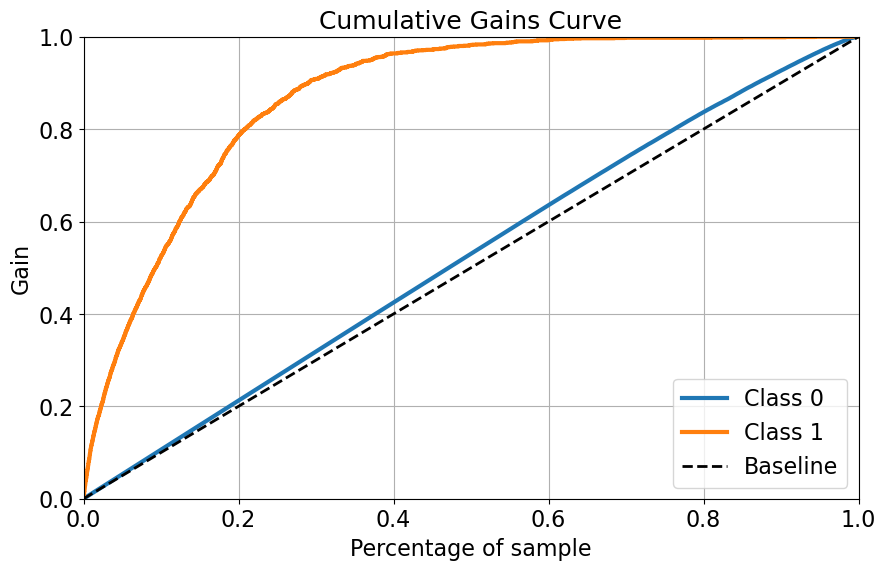

Lift Chart


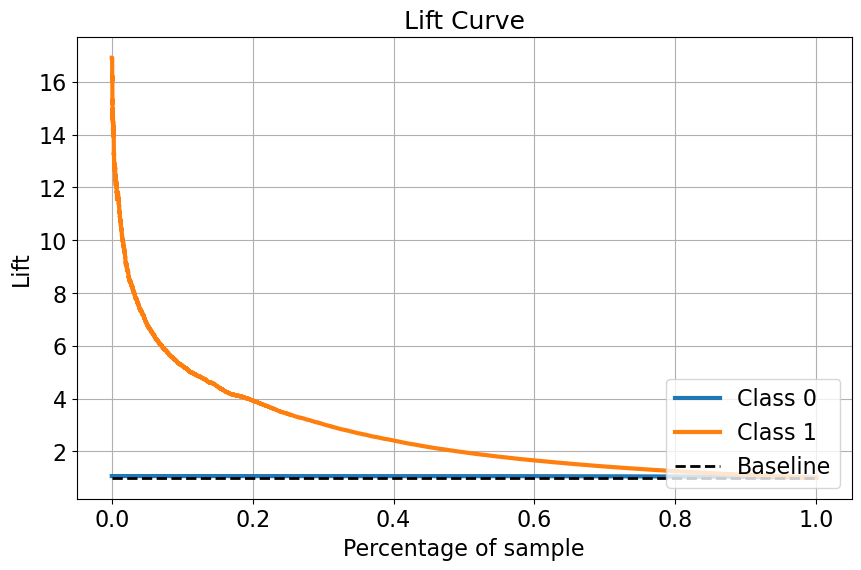

In [150]:
model_metrics(y_pred=model.predict(x_train.drop(columns=['application_id'])),y_true=y_train.fraud.values
              ,y_prob=model.predict_proba(x_train.drop(columns=['application_id'])))

Test Data Results

Accuracy Score: 0.8 

Confusion Matrix:
        pred:1  pred:0
true:1     632     142
true:0    2407    9844 

False Positive Rate: 0.2
True Positive Rate: 0.82
AUC: 0.81 

Sensitivity: 0.82
Specificity: 0.8 

F1 Score: 0.33 

KS Score:
KstestResult(statistic=0.1738963531669866, pvalue=1.1042631018369337e-172, statistic_location=0, statistic_sign=-1) 

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.89     12251
           1       0.21      0.82      0.33       774

    accuracy                           0.80     13025
   macro avg       0.60      0.81      0.61     13025
weighted avg       0.94      0.80      0.85     13025

Gain Chart


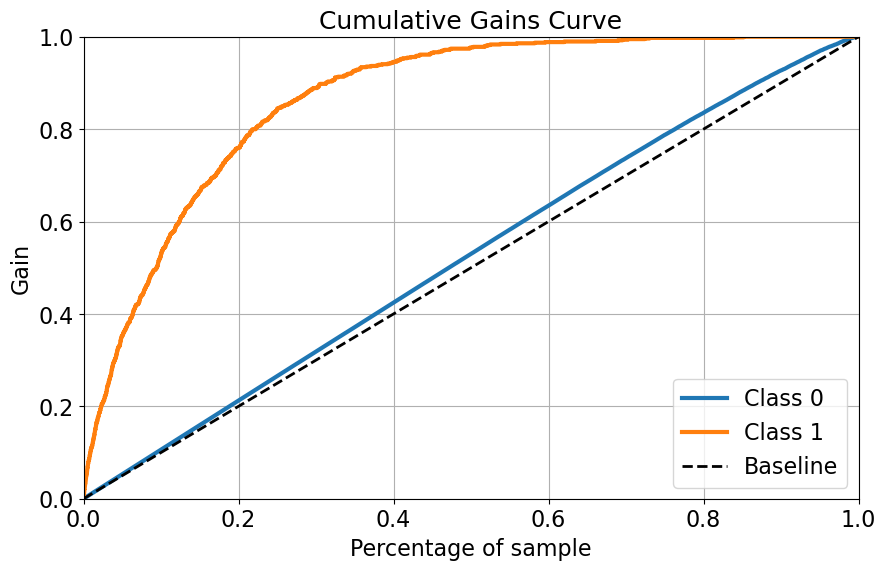

Lift Chart


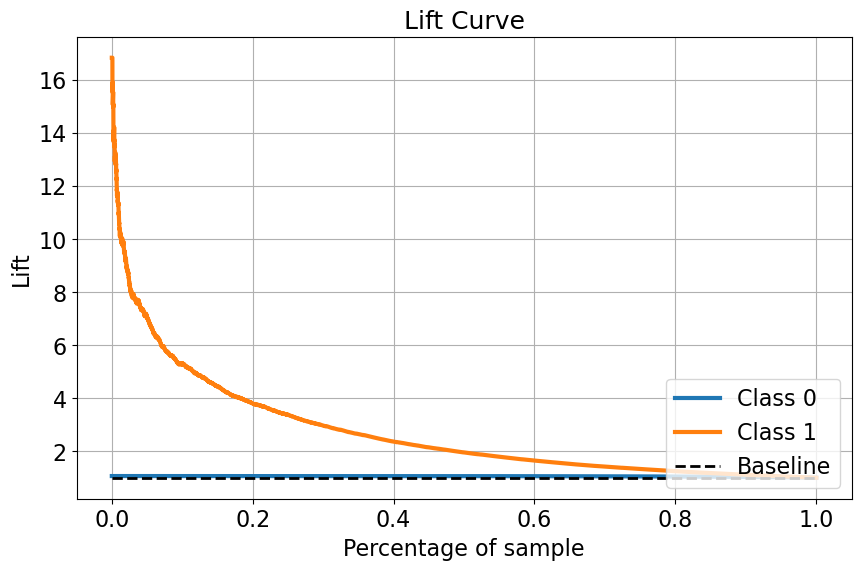

In [151]:
model_metrics(y_pred=model.predict(x_test.drop(columns=['application_id'])),y_true=y_test.fraud.values
              ,y_prob=model.predict_proba(x_test.drop(columns=['application_id'])))

Full Data

Accuracy Score: 0.81 

Confusion Matrix:
        pred:1  pred:0
true:1    2129     442
true:0    7975   32868 

False Positive Rate: 0.2
True Positive Rate: 0.83
AUC: 0.82 

Sensitivity: 0.83
Specificity: 0.8 

F1 Score: 0.34 

KS Score:
KstestResult(statistic=0.17351545584373707, pvalue=0.0, statistic_location=0, statistic_sign=-1) 

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.89     40843
           1       0.21      0.83      0.34      2571

    accuracy                           0.81     43414
   macro avg       0.60      0.82      0.61     43414
weighted avg       0.94      0.81      0.85     43414

Gain Chart


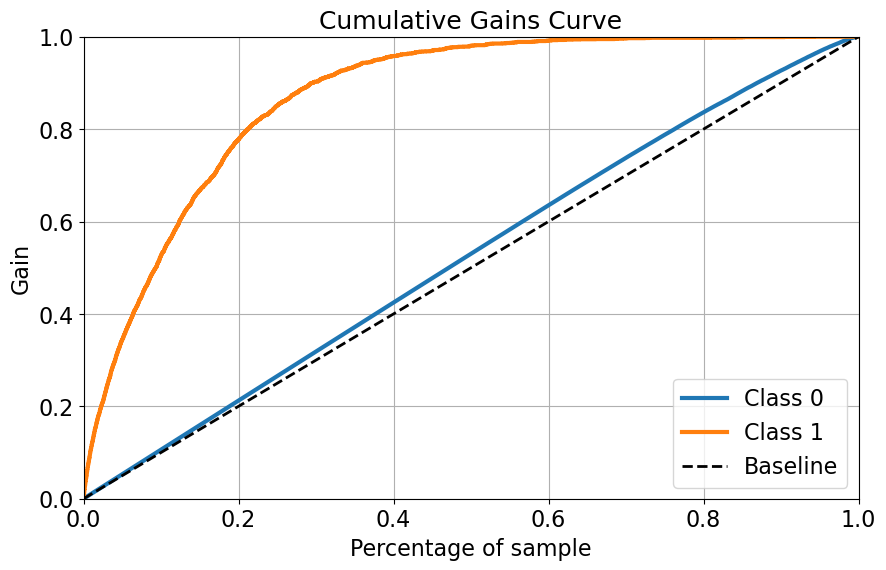

Lift Chart


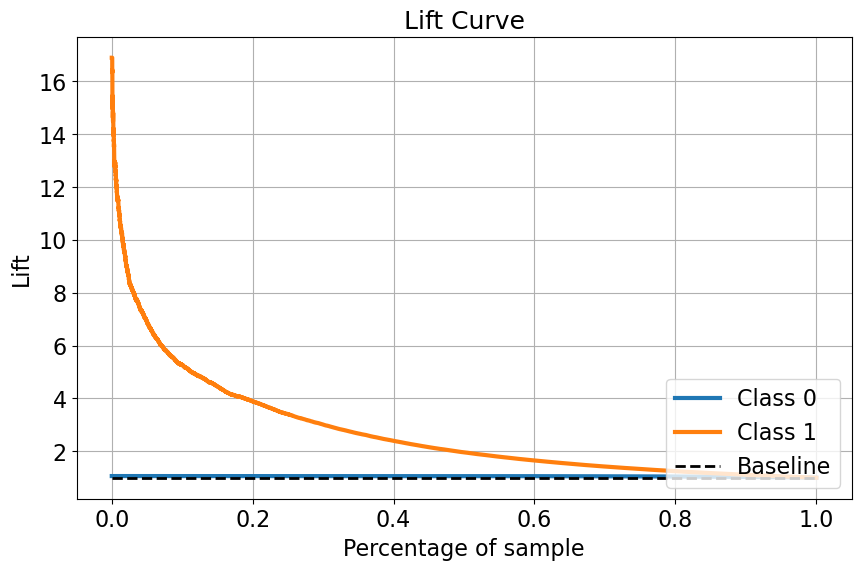

In [152]:
model_metrics(y_pred=model.predict(x.drop(columns=['application_id'])),y_true=y.fraud.values
              ,y_prob=model.predict_proba(x.drop(columns=['application_id'])))

### Binning Results

Train Results

In [153]:
features = list(x_train.drop(columns=['application_id']).columns)

pred_train_data = pd.DataFrame(zip(x_train.application_id.values, y_train.fraud.values 
                             ,Extract(model.predict_proba(x_train[features]).tolist())
                             ,model.predict(x_train[features]).tolist()
                            ), columns=['application_id','true_label','pred_prob','pred_label'])

pred_train_data['binned'] = pd.qcut(pred_train_data['pred_prob'], q=5)
fraud_rate(pred_train_data, 'true_label')

,bin,non_fraud_cnt,fraud_cnt,bin_fraud_rate%,vol_cum%,vol_fraud_rate_cum%,%_of_fraud_cum
0,"(0.0013700000000000001, 0.0304]",6076,4,0.07,20,0.01,0
1,"(0.0304, 0.094]",6067,9,0.15,40,0.04,0
2,"(0.094, 0.25]",6027,52,0.86,60,0.21,3
3,"(0.25, 0.549]",5756,320,5.27,79,1.27,21
4,"(0.549, 0.978]",4666,1412,23.23,100,5.91,100


Test Results

In [154]:
pred_test_data = pd.DataFrame(zip(x_test.application_id.values, y_test.fraud.values 
                             ,Extract(model.predict_proba(x_test[features]).tolist())
                             ,model.predict(x_test[features]).tolist()
                            ), columns=['application_id','true_label','pred_prob','pred_label'])

pred_test_data['binned'] = pd.qcut(pred_test_data['pred_prob'], q=5)
fraud_rate(pred_test_data, 'true_label')

,bin,non_fraud_cnt,fraud_cnt,bin_fraud_rate%,vol_cum%,vol_fraud_rate_cum%,%_of_fraud_cum
0,"(0.0013700000000000001, 0.0299]",2603,2,0.08,20,0.02,0
1,"(0.0299, 0.0927]",2598,7,0.27,40,0.07,1
2,"(0.0927, 0.249]",2571,34,1.31,60,0.33,5
3,"(0.249, 0.551]",2462,143,5.49,80,1.43,24
4,"(0.551, 0.978]",2017,588,22.57,100,5.94,100


Full Data

In [155]:
pred_full_data = pd.DataFrame(zip(x.application_id.values, y.fraud.values 
                             ,Extract(model.predict_proba(x[features]).tolist())
                             ,model.predict(x[features]).tolist()
                            ), columns=['application_id','true_label','pred_prob','pred_label'])

pred_full_data['binned'] = pd.qcut(pred_full_data['pred_prob'], q=5, labels=False)
fraud_rate(pred_full_data, 'true_label')

,bin,non_fraud_cnt,fraud_cnt,bin_fraud_rate%,vol_cum%,vol_fraud_rate_cum%,%_of_fraud_cum
0,0,8678,6,0.07,20,0.01,0
1,1,8666,16,0.18,40,0.05,0
2,2,8600,86,0.99,60,0.25,4
3,3,8230,465,5.35,80,1.32,22
4,4,6669,1998,23.05,100,5.92,100


#### Feature Importance

In [156]:
# pd.options.display.max_rows=500
df_features = feature_selection_iv(model=model, top_features=x.shape[1]-1)
df_features[df_features.value>0]


IV Based Feature Selection Started
The number of top features selected are 185

IV Based Feature Selection Completed


,feature,value
0,socure_phonerisk_reason_code_i609,0.107847
1,socure_emailrisk_reason_code_r566,0.086828
2,iovation_device_type_android,0.079548
3,iovation_device_type_mac,0.060113
4,iovation_device_type_windows,0.059674
5,socure_reason_code_i351,0.046020
6,number_of_employees,0.041021
7,socure_emailrisk_reason_code_i556,0.037154
8,socure_phonerisk_reason_code_i631,0.034223
9,industry_category_name_accommodation and food ...,0.032717


KS Decile Method: KS value should be in top 3 deciles or top 2 pentiles with >40%  

In [157]:
data = pred_test_data

df_ks = ks_decile(data=data ,target="true_label" ,prob="pred_prob", decile=True, n_decile=10, bins=None)
df_ks.drop(columns=['event_rate','nonevent_rate','KS','cum_noneventrate'], inplace=True)

df_ks.rename(columns={'event_rate':'fraud_rate','nonevent_rate':'non_fraud_rate','events':'fraud'
                      ,'nonevents':'non_fraud','cum_noneventrate':'cum_non_fraud_rate'
                     ,'cum_eventrate':'cum_fraud_rate'}, inplace=True)

df_ks2 = df_ks[['bin','fraud']]
df_ks2['vol'] = df_ks['fraud'] + df_ks['non_fraud']
df_ks2['fraud_rate'] = np.round(df_ks2['fraud']/df_ks2['vol'],4)
df_ks2.reset_index(drop=True, inplace=True)

df_ks2

KS is 62.6% at decile 3


,bin,fraud,vol,fraud_rate
0,"(0.707, 0.978]",408,1299,0.3141
1,"(0.551, 0.707]",180,1306,0.1378
2,"(0.389, 0.551]",100,1303,0.0767
3,"(0.249, 0.389]",43,1302,0.0330
4,"(0.161, 0.249]",25,1302,0.0192
5,"(0.0927, 0.161]",9,1303,0.0069
6,"(0.057, 0.0927]",4,1302,0.0031
7,"(0.0299, 0.057]",3,1303,0.0023
8,"(0.014, 0.0299]",2,1302,0.0015
9,"(0.0013700000000000001, 0.014]",0,1303,0.0000


##### Feature Importance Custom Function

In [158]:
def feature_importance(model, X, imp_type='gain'):
    '''
    Returns the best binary classifier with tuned hyperparameter set

        Parameters:
                model (object): model object of the binary classifier
                X (dataframe(pandas)): pandas dataframe of predictor variables in train dataset
                imp_type (str): importance type to be plotted from the model, choose from ['gain', 'cover', 'weight', 'total_gain', 'total_cover']
        
        Prints:
                feat_importances (plot): plots the feature importance

        Returns:
                feat_importance (dataframe(pandas)): pandas dataframe of feature importances

        Raises:
                ValueError: If X is not pandas dataframe
    '''
    # Check if train dataset is passed as dataframe
    if type(X) != pd.core.frame.DataFrame:
        raise ValueError('Train dataset not passed as pandas dataframe')
    
    # Check if the classifier is tree based
    if type(model).__name__ in (['DecisionTreeClassifier', 'RandomForestClassifier', 'XGBClassifier']):
        importance_array = model.feature_importances_
    else:
        importance_array = model.coef_[0]
    
    # Extract the feature importance
    feat_importances = pd.DataFrame(importance_array, index=X.columns, columns=['importance'])

    # Plot the feature importance
    # fig = px.bar(feat_importances, orientation='h')
    # fig.update_layout(yaxis={'categoryorder':'total ascending'})
    # fig.show()

    # Return the feature importance dataframe
    return feat_importances
imp = feature_importance(model, x_train.drop(columns=['application_id']), imp_type='gain')

In [159]:
# imp_idx = imp.sort_values(by='importance', ascending=False).index[:31]
# imp = imp.loc[imp_idx]

### Find the optimal number of features from the above top features

##### Build models with different feature counts

In [160]:
# functions to build models with different feature counts by iteratively removing least important features
def get_feature_importance(X_train, X_test):
    xgb_model = XGBClassifier(max_depth=2, colsample_bytree=0.7 ,subsample=0.7 ,scale_pos_weight=150 
                             ,learning_rate=0.1 ,random_state=3)
    xgb_model.fit(X_train, y_train)
    imp = feature_importance(xgb_model, X_train, imp_type='gain')
    return imp,xgb_model

def imp_iter(X_train,X_test,imp_data,threshold):
    X_train_temp = X_train.copy()
    X_test_temp = X_test.copy()
    while X_train_temp.shape[1] > threshold:
        features = list(X_train_temp.columns)
        feature_exc = imp_data.sort_values(by='importance', ascending=True).index[0]
        features.remove(feature_exc)
        X_train_temp = X_train_temp[features]
        X_test_temp = X_test_temp[features]
        imp_data, xgb_model = get_feature_importance(X_train_temp, X_test_temp)
    print(len(xgb_model.feature_names_in_))
    pickle.dump(xgb_model, open(f'{path}models/xgb_{threshold}.pkl', 'wb'))
    return

In [161]:
def var_imp_iter(X_train,X_test,imp_data,var_arr):
    for threshold in var_arr:
        imp_iter(X_train, X_test, imp_data, threshold)
    return

##### saving models with different feature counts

In [162]:
arr = [5,10,15,20,25,30]
var_imp_iter(x_train.drop(columns=['application_id']),x_test.drop(columns=['application_id']),imp,arr)

5
10
15
20
25
30


##### Loading models and comparing their AUC performance

In [163]:
features_count_arr = [30,25,20,15,10,5]
model_arr = []
for threshold in features_count_arr:
    model_arr.append(pickle.load(open(f'{path}models/xgb_{threshold}.pkl', "rb")))
model_arr

[XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=2, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=3, ...),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7, device=None, early_stopping_rounds=None,
               enable_categorical=Fa

##### Running iterations over 50 seeds

In [164]:
def run_pipe_test(df,  dependent_variable, model):
    # Set seed for train test split 
    selected_features = model.feature_names_in_
    traindict0, testdict0   = val.rank_order_test(df, selected_features, dependent_variable, model, 0)
    test = pd.DataFrame(columns=['seed','train_AUC', 'test_AUC'])
    dict1 = {'seed':0, 'train_AUC' : traindict0['AUC'], 'test_AUC' : testdict0['AUC']  }
    test = test.append(dict1,ignore_index=True)

    for seed in range(1,49):
        print(seed)
        traindict1, testdict1  = val.rank_order_test(df, selected_features, dependent_variable, model, seed)
        dict1 = {'seed':seed, 'train_AUC' : traindict1['AUC'], 'test_AUC' : testdict1['AUC']  }
        test = test.append(dict1,ignore_index=True)
    
    return test


In [165]:
aucdf = run_pipe_test(x_train.drop(columns=['application_id']).join(y_train),'fraud',model_arr[0])
aucdf['tag'] = 'base'

aucdf_main = aucdf.copy()

for tag,modelx in zip(features_count_arr,model_arr):
    aucdftmp = run_pipe_test(x_train.drop(columns=['application_id']).join(y_train),'fraud',modelx)
    aucdftmp['tag'] = tag
    aucdf_main = aucdf_main.append(aucdftmp)

0.48206646923330043
Accuracy Score: 0.49 

AUC: 0.73 

Accuracy Score: 0.48 

AUC: 0.72 

1
0.48404080289568935
Accuracy Score: 0.48 

AUC: 0.72 

Accuracy Score: 0.48 

AUC: 0.72 

2
0.5024679170779862
Accuracy Score: 0.5 

AUC: 0.73 

Accuracy Score: 0.5 

AUC: 0.73 

3
0.47735000548426015
Accuracy Score: 0.47 

AUC: 0.72 

Accuracy Score: 0.48 

AUC: 0.72 

4
0.4976417681254799
Accuracy Score: 0.5 

AUC: 0.73 

Accuracy Score: 0.5 

AUC: 0.72 

5
0.4823955248436986
Accuracy Score: 0.49 

AUC: 0.73 

Accuracy Score: 0.48 

AUC: 0.72 

6
0.48020182077437756
Accuracy Score: 0.49 

AUC: 0.72 

Accuracy Score: 0.48 

AUC: 0.72 

7
0.4966546012942854
Accuracy Score: 0.49 

AUC: 0.73 

Accuracy Score: 0.5 

AUC: 0.73 

8
0.489525063068992
Accuracy Score: 0.5 

AUC: 0.73 

Accuracy Score: 0.49 

AUC: 0.72 

9
0.512449270593397
Accuracy Score: 0.5 

AUC: 0.73 

Accuracy Score: 0.51 

AUC: 0.73 

10
0.5057584731819678
Accuracy Score: 0.51 

AUC: 0.74 

Accuracy Score: 0.51 

AUC: 0.73 

11
0.

In [166]:
aucdf_main = aucdf_main[~(aucdf_main['tag']=='base')]

##### Plotting AUCs

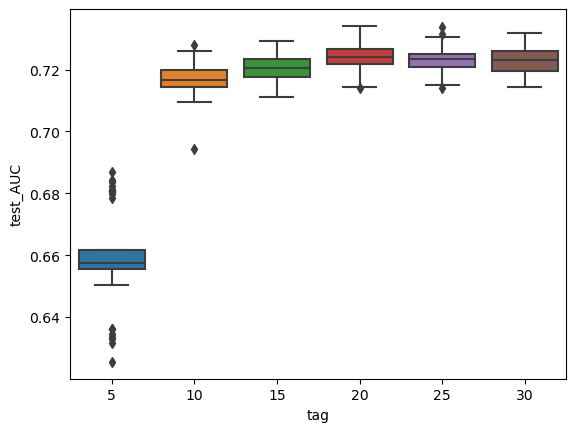

In [167]:
ax = sns.boxplot(x="tag", y="test_AUC", data=aucdf_main)  # RUN PLOT   
plt.show()

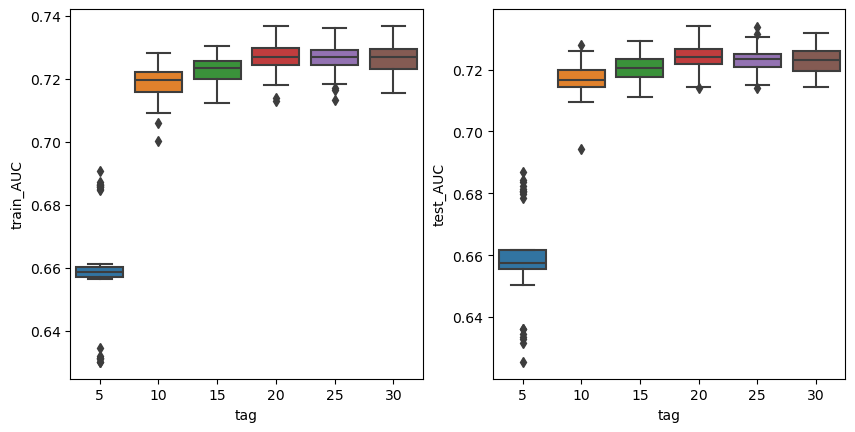

In [168]:
fig = plt.figure()
fig.set_figwidth(15)
fig.set_figwidth(10)
# fig.subplots_adjust(hspace=1, wspace=0.4)
ax = fig.add_subplot(1,2,1)
sns.boxplot(x="tag", y="train_AUC", data=aucdf_main,ax=ax)
ax = fig.add_subplot(1,2,2)
sns.boxplot(x="tag", y="test_AUC", data=aucdf_main,ax=ax)
plt.show()

#### Tuning the model for 15-features

In [170]:
# selecting the model with 15 features
model = model_arr[-3]

In [171]:
features = list(model.feature_names_in_) + ['application_id']

Select the top 15 features

In [172]:
x = x[features]
x.shape, y.shape

((43414, 16), (43414, 1))

### Model Building

Split Data

In [173]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed_num)

Rename column names

In [174]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
x_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in x_train.columns.values]
x_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in x_test.columns.values]

### Model Fit

The performance of the models are evaluated basis:
1) AUC difference between train & test < 4%

2) True Positive Rate >= 0.70 for both train & test

3) False Positve Rate <= 0.15 for both train & test

4) Rank ordering on both train & test

#### Grid Search

In [175]:
param_grid = {'max_depth': [2],
              'colsample_bytree': [0.5,0.7,0.9],
              'subsample': [0.5,0.7,0.9],
              'scale_pos_weight': [10,12,15],
              'learning_rate': [0.1,0.05],
              'random_state': [3],
              'n_estimators':[100]
             }

xgb_grid = GridSearchCV(xgboost.XGBClassifier(),
                      param_grid=param_grid,
                      scoring='roc_auc',
                      cv=4
                       )
xgb_grid.fit(x.drop(columns=['application_id']), y)


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.5, 0.7, 0.9],
                         'learning_rate': [0.1, 0.05], 'max_depth': [2],
                         'n_estimators': [100], 'random_state': [3],
                         'scale_pos_weight': [10, 12, 15],
                         'subsample': [0.5, 0.7, 0.9]},
             scoring='roc_auc')

In [176]:
xgb_grid.best_params_

{'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 100,
 'random_state': 3,
 'scale_pos_weight': 10,
 'subsample': 0.7}

In [177]:
model = xgb_grid.best_estimator_

Accuracy Score: 0.82 

Confusion Matrix:
        pred:1  pred:0
true:1    1390     407
true:0    5113   23479 

False Positive Rate: 0.18
True Positive Rate: 0.77
AUC: 0.8 

Sensitivity: 0.77
Specificity: 0.82 

F1 Score: 0.33 

KS Score:
KstestResult(statistic=0.15485866596465836, pvalue=1.158288e-318, statistic_location=0, statistic_sign=-1) 

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.82      0.89     28592
           1       0.21      0.77      0.33      1797

    accuracy                           0.82     30389
   macro avg       0.60      0.80      0.61     30389
weighted avg       0.94      0.82      0.86     30389

Gain Chart


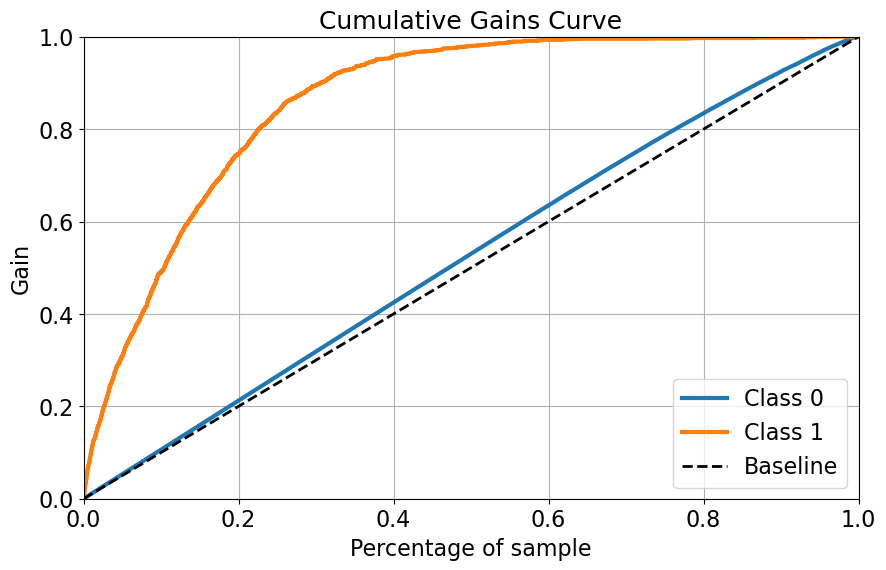

Lift Chart


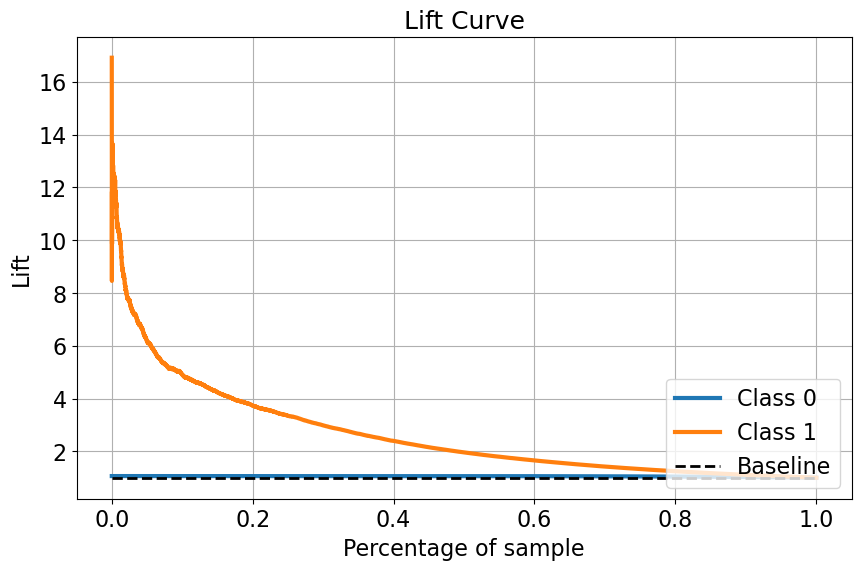

In [178]:
# Train Data Results
model_metrics(y_pred=model.predict(x_train.drop(columns=['application_id'])),y_true=y_train.fraud.values
              ,y_prob=model.predict_proba(x_train.drop(columns=['application_id'])))

Accuracy Score: 0.82 

Confusion Matrix:
        pred:1  pred:0
true:1     606     168
true:0    2178   10073 

False Positive Rate: 0.18
True Positive Rate: 0.78
AUC: 0.8 

Sensitivity: 0.78
Specificity: 0.82 

F1 Score: 0.34 

KS Score:
KstestResult(statistic=0.15431861804222646, pvalue=6.907605515956645e-136, statistic_location=0, statistic_sign=-1) 

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.82      0.90     12251
           1       0.22      0.78      0.34       774

    accuracy                           0.82     13025
   macro avg       0.60      0.80      0.62     13025
weighted avg       0.94      0.82      0.86     13025

Gain Chart


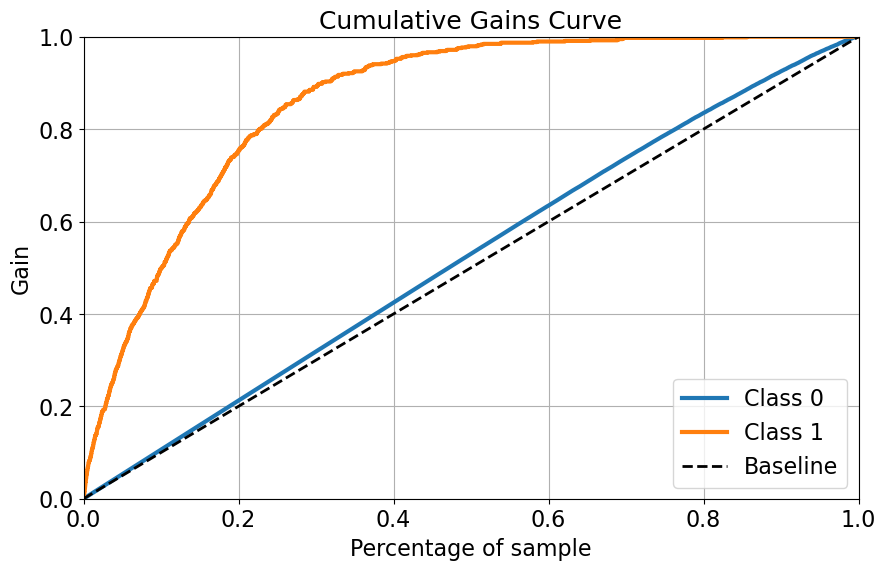

Lift Chart


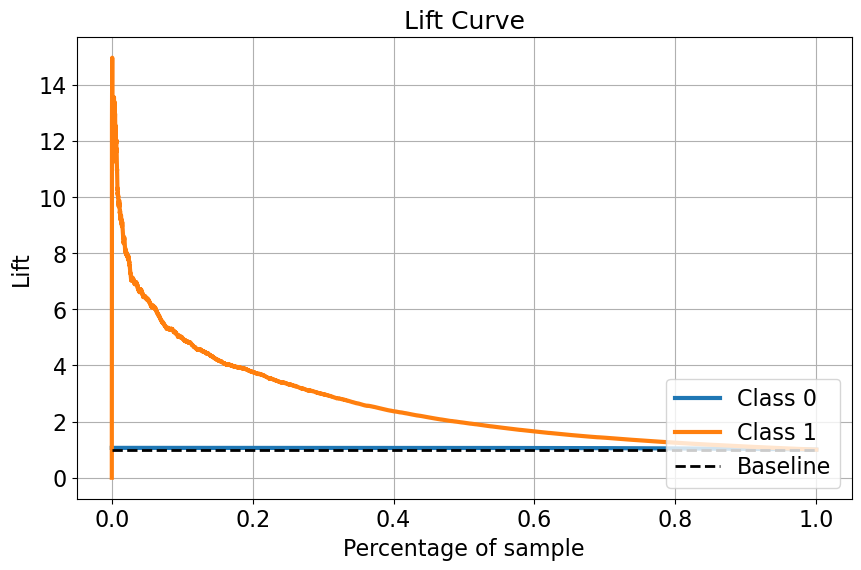

In [179]:
# Test Data Results
model_metrics(y_pred=model.predict(x_test.drop(columns=['application_id'])),y_true=y_test.fraud.values
              ,y_prob=model.predict_proba(x_test.drop(columns=['application_id'])))

In [180]:
# Train Results
features = list(x_train.drop(columns=['application_id']).columns)

pred_train_data = pd.DataFrame(zip(x_train.application_id.values, y_train.fraud.values 
                             ,Extract(model.predict_proba(x_train[features]).tolist())
                             ,model.predict(x_train[features]).tolist()
                            ), columns=['application_id','true_label','pred_prob','pred_label'])

pred_train_data['binned'] = pd.qcut(pred_train_data['pred_prob'], q=5)
fraud_rate(pred_train_data, 'true_label')


,bin,non_fraud_cnt,fraud_cnt,bin_fraud_rate%,vol_cum%,vol_fraud_rate_cum%,%_of_fraud_cum
0,"(0.00043000000000000004, 0.0194]",6073,5,0.08,20,0.02,0
1,"(0.0194, 0.0697]",6072,7,0.12,40,0.04,0
2,"(0.0697, 0.218]",6012,64,1.05,59,0.25,4
3,"(0.218, 0.526]",5746,384,6.26,80,1.51,25
4,"(0.526, 0.967]",4689,1337,22.19,100,5.91,100


In [181]:
# Test Results

pred_test_data = pd.DataFrame(zip(x_test.application_id.values, y_test.fraud.values 
                             ,Extract(model.predict_proba(x_test[features]).tolist())
                             ,model.predict(x_test[features]).tolist()
                            ), columns=['application_id','true_label','pred_prob','pred_label'])

pred_test_data['binned'] = pd.qcut(pred_test_data['pred_prob'], q=5)
fraud_rate(pred_test_data, 'true_label')

,bin,non_fraud_cnt,fraud_cnt,bin_fraud_rate%,vol_cum%,vol_fraud_rate_cum%,%_of_fraud_cum
0,"(0.00043000000000000004, 0.0186]",2608,2,0.08,20,0.02,0
1,"(0.0186, 0.0695]",2602,6,0.23,40,0.06,1
2,"(0.0695, 0.215]",2564,33,1.27,60,0.31,5
3,"(0.215, 0.526]",2463,151,5.78,80,1.47,24
4,"(0.526, 0.967]",2014,582,22.42,100,5.94,100


The best grid search estimator observations:
1) True Positive Rate condition failed on test

2) Failed rank order on test

#### GridSearch Model didn't satisfy the predefined conditions. So, tuning the "scale_pos_weight" by keeping other parameters constant to search the best fit model.

##### Models

In [ ]:
xgbc_100 = xgboost.XGBClassifier(max_depth=2, colsample_bytree=0.5 ,subsample=0.9 ,scale_pos_weight=100 
                             ,learning_rate=0.1 ,random_state=3)
xgbc_100.fit(x_train.drop(columns=['application_id']), y_train)
xgbc_150 = xgboost.XGBClassifier(max_depth=2, colsample_bytree=0.5 ,subsample=0.9 ,scale_pos_weight=150 
                             ,learning_rate=0.1 ,random_state=3)
xgbc_150.fit(x_train.drop(columns=['application_id']), y_train)
xgbc_180 = xgboost.XGBClassifier(max_depth=2, colsample_bytree=0.5 ,subsample=0.9 ,scale_pos_weight=180 
                             ,learning_rate=0.1 ,random_state=3)
xgbc_180.fit(x_train.drop(columns=['application_id']), y_train)

##### xgbc_100 Metrics

In [ ]:
# Train Data Results
model = xgbc_100
model_metrics(y_pred=model.predict(x_train.drop(columns=['application_id'])),y_true=y_train.fraud.values
              ,y_prob=model.predict_proba(x_train.drop(columns=['application_id'])))

In [ ]:
# Test Data Results
model_metrics(y_pred=model.predict(x_test.drop(columns=['application_id'])),y_true=y_test.fraud.values
              ,y_prob=model.predict_proba(x_test.drop(columns=['application_id'])))

In [ ]:
# Train Results
features = list(x_train.drop(columns=['application_id']).columns)

pred_train_data = pd.DataFrame(zip(x_train.application_id.values, y_train.fraud.values 
                             ,Extract(model.predict_proba(x_train[features]).tolist())
                             ,model.predict(x_train[features]).tolist()
                            ), columns=['application_id','true_label','pred_prob','pred_label'])

pred_train_data['binned'] = pd.qcut(pred_train_data['pred_prob'], q=5)
fraud_rate(pred_train_data, 'true_label')

In [ ]:
# Test Results
pred_test_data = pd.DataFrame(zip(x_test.application_id.values, y_test.fraud.values 
                             ,Extract(model.predict_proba(x_test[features]).tolist())
                             ,model.predict(x_test[features]).tolist()
                            ), columns=['application_id','true_label','pred_prob','pred_label'])

pred_test_data['binned'] = pd.qcut(pred_test_data['pred_prob'], q=5)
fraud_rate(pred_test_data, 'true_label')

xgbc_100 observation:

1) True Positive Rate condition failed on test

##### xgbc_150 Metrics

In [ ]:
# Train Data Results
model = xgbc_150
model_metrics(y_pred=model.predict(x_train.drop(columns=['application_id'])),y_true=y_train.fraud.values
              ,y_prob=model.predict_proba(x_train.drop(columns=['application_id'])))

In [ ]:
# Test Data Results
model_metrics(y_pred=model.predict(x_test.drop(columns=['application_id'])),y_true=y_test.fraud.values
              ,y_prob=model.predict_proba(x_test.drop(columns=['application_id'])))

In [ ]:
# Train Results
features = list(x_train.drop(columns=['application_id']).columns)

pred_train_data = pd.DataFrame(zip(x_train.application_id.values, y_train.fraud.values 
                             ,Extract(model.predict_proba(x_train[features]).tolist())
                             ,model.predict(x_train[features]).tolist()
                            ), columns=['application_id','true_label','pred_prob','pred_label'])

pred_train_data['binned'] = pd.qcut(pred_train_data['pred_prob'], q=5)
fraud_rate(pred_train_data, 'true_label')

In [ ]:
# Test Results
pred_test_data = pd.DataFrame(zip(x_test.application_id.values, y_test.fraud.values 
                             ,Extract(model.predict_proba(x_test[features]).tolist())
                             ,model.predict(x_test[features]).tolist()
                            ), columns=['application_id','true_label','pred_prob','pred_label'])

pred_test_data['binned'] = pd.qcut(pred_test_data['pred_prob'], q=5)
fraud_rate(pred_test_data, 'true_label')

xgbc_150 observation:

1) True Positive Rate condition failed on test

2) Failed rank order on both train and test data


##### xgbc_180 Metrics

In [ ]:
# Train Data Results
model = xgbc_180
model_metrics(y_pred=model.predict(x_train.drop(columns=['application_id'])),y_true=y_train.fraud.values
              ,y_prob=model.predict_proba(x_train.drop(columns=['application_id'])))

In [ ]:
# Test Data Results
model_metrics(y_pred=model.predict(x_test.drop(columns=['application_id'])),y_true=y_test.fraud.values
              ,y_prob=model.predict_proba(x_test.drop(columns=['application_id'])))

In [ ]:
# Train Results
features = list(x_train.drop(columns=['application_id']).columns)

pred_train_data = pd.DataFrame(zip(x_train.application_id.values, y_train.fraud.values 
                             ,Extract(model.predict_proba(x_train[features]).tolist())
                             ,model.predict(x_train[features]).tolist()
                            ), columns=['application_id','true_label','pred_prob','pred_label'])

pred_train_data['binned'] = pd.qcut(pred_train_data['pred_prob'], q=5)
fraud_rate(pred_train_data, 'true_label')

In [ ]:
# Test Results
pred_test_data = pd.DataFrame(zip(x_test.application_id.values, y_test.fraud.values 
                             ,Extract(model.predict_proba(x_test[features]).tolist())
                             ,model.predict(x_test[features]).tolist()
                            ), columns=['application_id','true_label','pred_prob','pred_label'])

pred_test_data['binned'] = pd.qcut(pred_test_data['pred_prob'], q=5)
fraud_rate(pred_test_data, 'true_label')

xgbc_180 observation:

1) False Positive Rate condition failed on train & test data

2) Failed rank order on test data


### None of the grid search based models (best estimator, xgbc_100, xgbc_150 & xgbc_180) satisfied the predefined metrics. 

So, tuning the parameters "colsample_bytree" and "subsample" to optimal values to find the best model fit.

### Fine tune the parameters "colsample_bytree", "subsample" and "scale_pos_weight".
1) Setting the colsample_bytree=0.7 with an increase by 0.2 and subsample=0.7 with an decrease by 0.2 basis best grid search estimator. These values are chosen to control the overfitting and also to retain the randomness in the data basis gridsearch

2) Tune the scale_pos_weight: 100,120,150,180

##### Models

In [ ]:
xgbc_100 = xgboost.XGBClassifier(max_depth=2, colsample_bytree=0.7 ,subsample=0.7 ,scale_pos_weight=100 
                             ,learning_rate=0.1 ,random_state=3)
xgbc_100.fit(x_train.drop(columns=['application_id']), y_train)

xgbc_120 = xgboost.XGBClassifier(max_depth=2, colsample_bytree=0.7 ,subsample=0.7 ,scale_pos_weight=120 
                             ,learning_rate=0.1 ,random_state=3)
xgbc_120.fit(x_train.drop(columns=['application_id']), y_train)

xgbc_150 = xgboost.XGBClassifier(max_depth=2, colsample_bytree=0.7 ,subsample=0.7 ,scale_pos_weight=150 
                             ,learning_rate=0.1 ,random_state=3)
xgbc_150.fit(x_train.drop(columns=['application_id']), y_train)

xgbc_180 = xgboost.XGBClassifier(max_depth=2, colsample_bytree=0.7 ,subsample=0.7 ,scale_pos_weight=180 
                             ,learning_rate=0.1 ,random_state=3)
xgbc_180.fit(x_train.drop(columns=['application_id']), y_train)

##### xgbc_180 Metrics

In [ ]:
model = xgbc_180

In [ ]:
# Train Data Results
model_metrics(y_pred=model.predict(x_train.drop(columns=['application_id'])),y_true=y_train.fraud.values
              ,y_prob=model.predict_proba(x_train.drop(columns=['application_id'])))

In [ ]:
# Test Data Results
model_metrics(y_pred=model.predict(x_test.drop(columns=['application_id'])),y_true=y_test.fraud.values
              ,y_prob=model.predict_proba(x_test.drop(columns=['application_id'])))

In [ ]:
# Train Results
features = list(x_train.drop(columns=['application_id']).columns)

pred_train_data = pd.DataFrame(zip(x_train.application_id.values, y_train.fraud.values 
                             ,Extract(model.predict_proba(x_train[features]).tolist())
                             ,model.predict(x_train[features]).tolist()
                            ), columns=['application_id','true_label','pred_prob','pred_label'])

pred_train_data['binned'] = pd.qcut(pred_train_data['pred_prob'], q=5)
fraud_rate(pred_train_data, 'true_label')

In [ ]:
# Test Results
pred_test_data = pd.DataFrame(zip(x_test.application_id.values, y_test.fraud.values 
                             ,Extract(model.predict_proba(x_test[features]).tolist())
                             ,model.predict(x_test[features]).tolist()
                            ), columns=['application_id','true_label','pred_prob','pred_label'])

pred_test_data['binned'] = pd.qcut(pred_test_data['pred_prob'], q=5)
fraud_rate(pred_test_data, 'true_label')

xgbc_180 observation:

1) AUC condition failed

2) False Positive Rate condition failed on both train & test

##### xgbc_150 Metrics

In [ ]:
model = xgbc_150

In [ ]:
# Train Data Results
model_metrics(y_pred=model.predict(x_train.drop(columns=['application_id'])),y_true=y_train.fraud.values
              ,y_prob=model.predict_proba(x_train.drop(columns=['application_id'])))

In [ ]:
# Test Data Results
model_metrics(y_pred=model.predict(x_test.drop(columns=['application_id'])),y_true=y_test.fraud.values
              ,y_prob=model.predict_proba(x_test.drop(columns=['application_id'])))

In [ ]:
# Train Results
features = list(x_train.drop(columns=['application_id']).columns)

pred_train_data = pd.DataFrame(zip(x_train.application_id.values, y_train.fraud.values 
                             ,Extract(model.predict_proba(x_train[features]).tolist())
                             ,model.predict(x_train[features]).tolist()
                            ), columns=['application_id','true_label','pred_prob','pred_label'])

pred_train_data['binned'] = pd.qcut(pred_train_data['pred_prob'], q=5)
fraud_rate(pred_train_data, 'true_label')

In [ ]:
# Test Results
pred_test_data = pd.DataFrame(zip(x_test.application_id.values, y_test.fraud.values 
                             ,Extract(model.predict_proba(x_test[features]).tolist())
                             ,model.predict(x_test[features]).tolist()
                            ), columns=['application_id','true_label','pred_prob','pred_label'])

pred_test_data['binned'] = pd.qcut(pred_test_data['pred_prob'], q=5)
fraud_rate(pred_test_data, 'true_label')

xgbc_150 observation: All conditions are satisfied 

##### xgbc_120 Metrics

In [ ]:
model = xgbc_120

In [ ]:
# Train Data Results
model_metrics(y_pred=model.predict(x_train.drop(columns=['application_id'])),y_true=y_train.fraud.values
              ,y_prob=model.predict_proba(x_train.drop(columns=['application_id'])))

In [ ]:
# Test Data Results
model_metrics(y_pred=model.predict(x_test.drop(columns=['application_id'])),y_true=y_test.fraud.values
              ,y_prob=model.predict_proba(x_test.drop(columns=['application_id'])))

In [ ]:
# Train Results
features = list(x_train.drop(columns=['application_id']).columns)

pred_train_data = pd.DataFrame(zip(x_train.application_id.values, y_train.fraud.values 
                             ,Extract(model.predict_proba(x_train[features]).tolist())
                             ,model.predict(x_train[features]).tolist()
                            ), columns=['application_id','true_label','pred_prob','pred_label'])

pred_train_data['binned'] = pd.qcut(pred_train_data['pred_prob'], q=5)
fraud_rate(pred_train_data, 'true_label')

In [ ]:
# Test Results
pred_test_data = pd.DataFrame(zip(x_test.application_id.values, y_test.fraud.values 
                             ,Extract(model.predict_proba(x_test[features]).tolist())
                             ,model.predict(x_test[features]).tolist()
                            ), columns=['application_id','true_label','pred_prob','pred_label'])

pred_test_data['binned'] = pd.qcut(pred_test_data['pred_prob'], q=5)
fraud_rate(pred_test_data, 'true_label')

xgbc_120 observations: 
1) AUC condition failed

2) True Positive Rate condition failed

##### xgbc_100 Metrics

In [ ]:
model = xgbc_100

In [ ]:
# Train Data Results
model_metrics(y_pred=model.predict(x_train.drop(columns=['application_id'])),y_true=y_train.fraud.values
              ,y_prob=model.predict_proba(x_train.drop(columns=['application_id'])))

In [ ]:
# Test Data Results
model_metrics(y_pred=model.predict(x_test.drop(columns=['application_id'])),y_true=y_test.fraud.values
              ,y_prob=model.predict_proba(x_test.drop(columns=['application_id'])))

In [ ]:
# Train Results
features = list(x_train.drop(columns=['application_id']).columns)

pred_train_data = pd.DataFrame(zip(x_train.application_id.values, y_train.fraud.values 
                             ,Extract(model.predict_proba(x_train[features]).tolist())
                             ,model.predict(x_train[features]).tolist()
                            ), columns=['application_id','true_label','pred_prob','pred_label'])

pred_train_data['binned'] = pd.qcut(pred_train_data['pred_prob'], q=5)
fraud_rate(pred_train_data, 'true_label')

In [ ]:
# Test Results
pred_test_data = pd.DataFrame(zip(x_test.application_id.values, y_test.fraud.values 
                             ,Extract(model.predict_proba(x_test[features]).tolist())
                             ,model.predict(x_test[features]).tolist()
                            ), columns=['application_id','true_label','pred_prob','pred_label'])

pred_test_data['binned'] = pd.qcut(pred_test_data['pred_prob'], q=5)
fraud_rate(pred_test_data, 'true_label')

xgbc_100 observations: 
1) True Positive Rate condition failed

2) Failed rank order 

### Best Model selected is xgbc_150

In [ ]:
model = xgbc_150

Feature Importance

In [ ]:
df_features = feature_selection_iv(model=model, top_features=30)
df_features

Save the model

In [ ]:
# model_name = 'onboarding_fraud_model_v2_150'
# model_path = '../models/'+model_name+'.pkl'
# pickle.dump(xgbc_150, open(model_path, 'wb'))